In [1]:
import json
import pathlib
import pycolmap
import datetime

import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.utils.tensorboard import SummaryWriter

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import neural_orientation_field.utils as utils
import neural_orientation_field.colmap.colmap_utils as colutils

In [2]:
# Seed rng for reproducability
np.random.seed(42)
torch.manual_seed(42)

# Load Dataset

In [3]:
# Neural Orientation Field config
CONFIG_PATH = "../../../nof-config.json"
COLMAP_MODEL_PATH = "../../../data/cache/colmap/0/"

with open(CONFIG_PATH, "r") as config_file:
    config_dict = json.load(config_file)
project_config = utils.ProjectConfig.from_dict(config_dict)
image_dir = project_config.input_path
colmap_model_path = pathlib.Path(COLMAP_MODEL_PATH).resolve()

image_dir, colmap_model_path

(PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/images/weiran-cap-low-res'),
 PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/cache/colmap/0'))

In [4]:
# Load COLMAP reconstruction
colmap_model = pycolmap.Reconstruction(colmap_model_path)
print(colmap_model.summary())

Reconstruction:
	num_reg_images = 41
	num_cameras = 1
	num_points3D = 3053
	num_observations = 13801
	mean_track_length = 4.52047
	mean_observations_per_image = 336.61
	mean_reprojection_error = 0.558984


In [5]:
num_images = colmap_model.num_reg_images()
cam_transforms, cam_params, image_file_names = colutils.get_camera_poses(colmap_model)
num_images, cam_transforms.shape, cam_params.shape, len(image_file_names)

(41, (41, 4, 4), (41, 3), 41)

In [6]:
images = []
# From view coordinate to world coordinate.
cam_transforms_inv = []
cam_origs = []
cam_rays = []
cam_focals = []
for idx in range(num_images):
    # Convert image to (h, w, 3) np.ndarray.
    image = Image.open(image_dir / image_file_names[idx])
    image = np.array(image)
    images.append(image)
    h, w, _ = image.shape
    # Camera parameters.
    f, cx, cy = cam_params[idx]
    cam_focals.append(f)
    # Camera pose.
    cam_transform = cam_transforms[idx]
    cam_transform_inv = np.linalg.inv(cam_transform)
    cam_transforms_inv.append(cam_transform_inv)
    # Calculate camera origins
    cam_orig = np.matmul(cam_transform_inv, np.array([0, 0, 0, 1]))[:3]
    cam_origs.append(cam_orig)
    # Calculate camera ray.
    pixel_coord = np.moveaxis(np.mgrid[0:h, 0:w], 0, -1) - np.array([cx, cy])
    cam_ray_view = np.append(pixel_coord, f * np.ones((h, w, 1)), axis=2)
    cam_ray_view_homo = np.append(cam_ray_view, np.zeros((h, w, 1)), axis=2)
    cam_ray_world = np.matmul(
        cam_transform_inv[np.newaxis, np.newaxis, :, :],
        cam_ray_view_homo[:, :, :, np.newaxis]
    ).reshape((h, w, -1))[:, :, :3]
    cam_rays.append(cam_ray_world)

# WARNING: This may fail if images are not captured by the same camera.
images = np.array(images) / 256
cam_transforms_inv = np.array(cam_transforms_inv)
cam_origs = np.array(cam_origs)
cam_rays = np.array(cam_rays) / np.linalg.norm(np.array(cam_rays), axis=-1)[:, :, :, np.newaxis]
cam_focals = np.array(cam_focals)

images.shape, cam_transforms.shape, cam_transforms_inv.shape, cam_origs.shape, cam_rays.shape, cam_focals.shape

((41, 428, 571, 3), (41, 4, 4), (41, 4, 4), (41, 3), (41, 428, 571, 3), (41,))

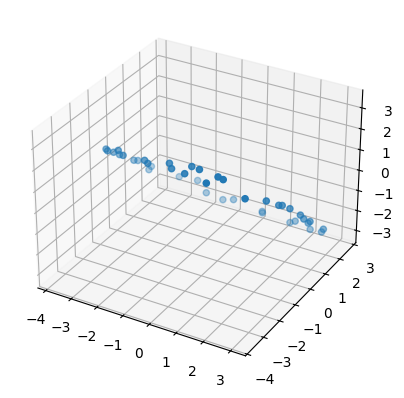

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(cam_origs[:, 0], cam_origs[:, 1], cam_origs[:, 2])

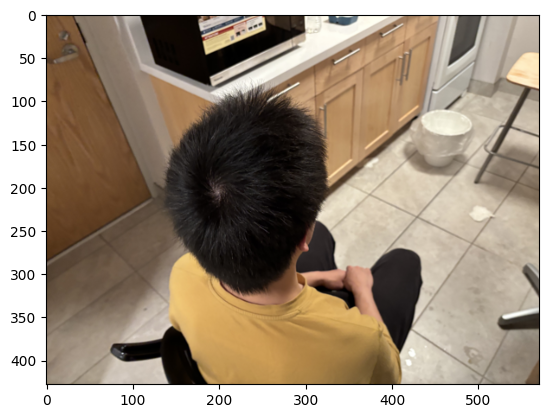

In [8]:
idx = 1
image = images[idx]
plt.imshow(image)

In [9]:
np.savez("tiny_nerf_data", images=images, poses=cam_transforms_inv, focal=cam_focals[0])

# NeRF

In [10]:
# Use MPS device.
USE_DEVICE = "cuda"

if USE_DEVICE == "mps" and torch.mps.is_available():
    device = torch.device("mps")
elif USE_DEVICE == "cuda" and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='mps')

## Nerf Model

In [11]:
# Nerf model.
class TinyNerfModel(torch.nn.Module):
    def __init__(self, filter_size=128, num_encoding_functions=6):
        super(TinyNerfModel, self).__init__()
        # Input layer (default: 42 -> 128)
        # 3 (position) + 3 (direction) + 3 * 2 * 6 (6 sin and cos encoding for position only)
        self.layer1 = torch.nn.Linear(
            3 * 2 + 3 * 2 * num_encoding_functions,
            filter_size
        )
        # Layer 2 (default: 128 -> 128)
        self.layer2 = torch.nn.Linear(filter_size, filter_size)
        # Layer 3 (default: 128 -> 4)
        self.layer3 = torch.nn.Linear(filter_size, 4)
        # Short hand for torch.nn.functional.relu
        self.relu = torch.nn.functional.relu

    def forward(self, x: torch.Tensor):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Positional encoding.
def pos_encode(x: torch.Tensor, num_encoding_functions=6):
    """
    x: (n, 3) tensor of n positions.
    return: (n, num_encoding_functions, 3) encoded positions
    """
    p = torch.arange(num_encoding_functions, device=device)
    x = torch.pow(2, p)[torch.newaxis, :, torch.newaxis] * x[:, torch.newaxis, :]
    x = torch.concat((torch.sin(x), torch.cos(x)), 1)
    return x

## Volumetric Rendering

In [12]:
# Volumetric rendering using NeRF model, camera_origs, and camera_rays
def volumetric_rendering(
    model: torch.nn.Module,
    camera_origs: torch.Tensor,
    camera_rays: torch.Tensor,
    nc: torch.float32,
    fc: torch.float32,
    num_sample: int,
    sample_jitter: float = 0.1,
    num_pos_encode: int = 6,
):
    n, _ = camera_origs.shape
    # Expand ray to multiple samples.
    sample_depths = torch.linspace(nc, fc, num_sample, device=device)
    sample_depths = sample_depths.unsqueeze(0).expand(n, -1)
    # Improve convergence by introducing random sample.
    interval = (fc - nc) / (num_sample - 1)
    sample_depths = sample_depths + (torch.rand(sample_depths.shape, device=device) - 0.5) * interval * sample_jitter
    sample_pos = camera_origs[:, torch.newaxis, :] + camera_rays[:, torch.newaxis, :] * sample_depths[:, :, torch.newaxis]
    sample_direct = camera_rays.unsqueeze(1).expand((-1, num_sample, -1))

    # Send samples to NeRF.
    sample_pos = sample_pos.reshape(-1, 3)
    sample_direct = sample_direct.reshape(-1, 3)
    sample_pos_encode = pos_encode(sample_pos, num_pos_encode)

    # Eval radiance from NeRF
    nerf_input = torch.concat((sample_pos.unsqueeze(1), sample_direct.unsqueeze(1), sample_pos_encode), 1).reshape(n * num_sample, -1)
    radiance = model(nerf_input)
    radiance = radiance.reshape(n, num_sample, -1)

    # Integrate color.
    sample_depths_diff = sample_depths[:, 1:] - sample_depths[:, :-1]
    sample_depths_diff = torch.concat((sample_depths_diff, torch.ones((n, 1), device=device) * interval), dim=1)
    color = radiance[:, :, 0:3] * radiance[:, :, 3].unsqueeze(-1) * sample_depths_diff[:, :, torch.newaxis]
    color = torch.sum(color, 1)
    color = torch.sigmoid(color)
    return color

# NeRF Training

In [13]:
# Near/far clipping distance.
nc = 1
fc = 8
# Positional encoding number.
num_pos_encode = 4
samples_per_ray = 16
# Hyper parameters.
lr = 5e-3
num_iters = 10
ray_batch_size = 5000

# Init model.
model = TinyNerfModel(num_encoding_functions=num_pos_encode)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [14]:
# Show volumetric rendering.
def render_nerf(idx = -1):
    image_eval, cam_orig_eval, cam_ray_eval = images[idx], cam_origs[idx], cam_rays[idx]
    image_eval = torch.from_numpy(image_eval).type(torch.float32).to(device)
    cam_orig_eval = torch.from_numpy(cam_orig_eval).type(torch.float32).to(device)
    cam_orig_eval = cam_orig_eval.view(1, 1, -1)
    cam_orig_eval = cam_orig_eval.expand(image_eval.shape)
    cam_ray_eval = torch.from_numpy(cam_ray_eval).type(torch.float32).to(device)
    image_eval.shape, cam_orig_eval.shape, cam_ray_eval.shape
    model.eval()
    color_pred = volumetric_rendering(
        model,
        cam_orig_eval.reshape(-1, 3),
        cam_ray_eval.reshape(-1, 3),
        nc,
        fc,
        num_sample=samples_per_ray,
        num_pos_encode=num_pos_encode
    )
    image_pred = color_pred.reshape(image_eval.shape)
    return image_eval, image_pred

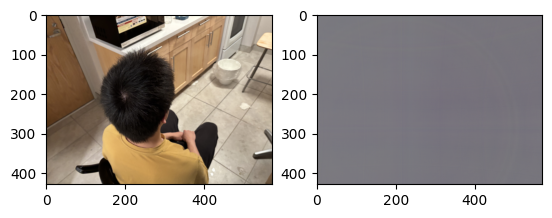

In [15]:
image_eval, image_pred = render_nerf(1)
fig, (ax_image, ax_pred) = plt.subplots(1, 2)
ax_image.imshow(image_eval.cpu())
ax_pred.imshow(image_pred.detach().cpu())

In [16]:
class NeRFDataset(Dataset):    
    def __init__(self, images, cam_origs, cam_rays):
        cam_origs = np.broadcast_to(cam_origs[:, np.newaxis, np.newaxis, :], images.shape)
        self.colors = images.reshape(-1, 3)
        self.cam_origs = cam_origs.reshape(-1, 3)
        self.cam_rays = cam_rays.reshape(-1, 3)

    # get sample
    def __getitem__(self, idx):
        return self.colors[idx], self.cam_origs[idx], self.cam_rays[idx]

    def __len__(self):
        return len(self.colors)

In [17]:
model.train()

dataset = NeRFDataset(images[:-1], cam_origs[:-1], cam_rays[:-1])
train_sampler = RandomSampler(data_source=dataset, num_samples=int(1 * len(dataset)))
dataloader = DataLoader(
    dataset,
    sampler=train_sampler,
    batch_size=ray_batch_size,
)

writer = SummaryWriter(log_dir=project_config.cache_path / "tensor-board" / datetime.datetime.now().isoformat(), flush_secs=1)
for it in tqdm(range(num_iters)):
    # One iteration of the training.
    for batch_i, (color_batch, cam_orig_batch, cam_ray_batch) in enumerate(tqdm(dataloader)):
        color_batch = color_batch.type(torch.float32).to(device)
        cam_orig_batch = cam_orig_batch.type(torch.float32).to(device)
        cam_ray_batch = cam_ray_batch.type(torch.float32).to(device)
        
        color_pred = volumetric_rendering(
            model,
            cam_orig_batch.reshape(-1, 3),
            cam_ray_batch.reshape(-1, 3),
            nc,
            fc,
            num_sample=samples_per_ray,
            num_pos_encode=num_pos_encode
        )
        loss = torch.nn.functional.mse_loss(color_pred, color_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        writer.add_scalar("MSE Loss", loss, it * len(dataloader) + batch_i)
    image_eval, image_pred = render_nerf(-1)
    writer.add_image("Eval Image", image_eval, it, dataformats="HWC")
    writer.add_image("Pred Image", image_pred, it, dataformats="HWC")
writer.close()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1956 [00:00<?, ?it/s]

  0%|          | 0/1956 [00:00<?, ?it/s]

  0%|          | 0/1956 [00:00<?, ?it/s]

  0%|          | 0/1956 [00:00<?, ?it/s]

  0%|          | 0/1956 [00:00<?, ?it/s]

  0%|          | 0/1956 [00:00<?, ?it/s]

  0%|          | 0/1956 [00:00<?, ?it/s]

  0%|          | 0/1956 [00:00<?, ?it/s]

  0%|          | 0/1956 [00:00<?, ?it/s]

  0%|          | 0/1956 [00:00<?, ?it/s]

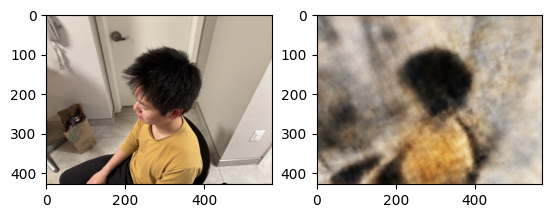

In [21]:
image_eval, image_pred = render_nerf(10)
fig, (ax_image, ax_pred) = plt.subplots(1, 2)
ax_image.imshow(image_eval.cpu())
ax_pred.imshow(image_pred.detach().cpu())